### Preprocess Class

In [12]:
import pickle
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler  # You can change to StandardScaler if preferred

class DataPreprocessor:
    def __init__(self, integer_cols, nominal_cols, binary_cols, important_features):
        self.integer_cols = integer_cols
        self.nominal_cols = nominal_cols
        self.binary_cols = binary_cols
        self.important_features = important_features
        self.label_encoders = {}
        self.scaler = MinMaxScaler()  # You can use StandardScaler() here if needed

    def preprocess(self, data):
        # Remove missing values and duplicates
        data = data.dropna()
        data = data.drop_duplicates()

        # Remove 'id' column if it exists
        if 'id' in data.columns:
            data = data.drop(['id'], axis=1)

        # Drop unused columns
        data = self.drop_unused_columns(data)

        # Encode nominal (categorical) columns
        for col in self.nominal_cols:
            if col in data.columns:
                le = LabelEncoder()
                data[col] = le.fit_transform(data[col])
                self.label_encoders[col] = le  # Store the encoder for inverse transform if needed

        # Apply log transformation to integer columns
        for col in self.integer_cols:
            if col in data.columns:
                data[col] = np.log(data[col] + 1)  # Adding 1 to avoid log(0)

        # Apply scaling to integer columns after log transformation
        data = self.scale_columns(data)

        return data

    def drop_unused_columns(self, data):
        """
        Drops columns that are not in the list of important features.
        """
        # Get the columns to drop (those not in the important_features list)
        columns_to_drop = [col for col in data.columns if col not in self.important_features]

        # Drop those columns from the data
        data = data.drop(columns=columns_to_drop, axis=1)

        return data

    def scale_columns(self, data):
        """
        Apply scaling to integer columns.
        """
        if self.integer_cols:
            data[self.integer_cols] = self.scaler.fit_transform(data[self.integer_cols])
        return data

    def inverse_transform(self, data, column):
        """
        If needed, revert the encoding for a specific column.
        """
        if column in self.label_encoders:
            le = self.label_encoders[column]
            data[column] = le.inverse_transform(data[column])
        return data
    
    def inverse_log_transform(self, data):
        """
        Revert the log transformation for integer columns.
        """
        for col in self.integer_cols:
            if col in data.columns:
                data[col] = np.exp(data[col]) - 1
        return data
    
    def save_label_encoders(self, filename):
        """
        Save the label encoders to a file.
        """
        with open(filename, 'wb') as f:
            pickle.dump(self.label_encoders, f)

    def load_label_encoders(self, filename):
        """
        Load the label encoders from a file.
        """
        if os.path.exists(filename):
            with open(filename, 'rb') as f:
                self.label_encoders = pickle.load(f)
        else:
            print(f"File {filename} does not exist.")

    def save_scaler(self, filename):
        """
        Save the scaler to a file.
        """
        with open(filename, 'wb') as f:
            pickle.dump(self.scaler, f)

    def load_scaler(self, filename):
        """
        Load the scaler from a file.
        """
        if os.path.exists(filename):
            with open(filename, 'rb') as f:
                self.scaler = pickle.load(f)
        else:
            print(f"File {filename} does not exist.")



### Data Extractor Class 

In [15]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

class DataExtractor:
    def __init__(self, data):
        """
        Initializes the DataExtractor with a dataset.

        :param data: pandas DataFrame containing the dataset
        """
        self.data = data

    def random_sample(self, sample_size, random_state=None):
        """
        Returns a random sample of the dataset.

        :param sample_size: Number or proportion of samples to extract (int for number, float for proportion).
        :param random_state: Seed for reproducibility (optional).
        :return: A pandas DataFrame containing the random sample.
        """
        sample_data = self.data.sample(n=sample_size if isinstance(sample_size, int) else None,
                                       frac=sample_size if isinstance(sample_size, float) else None,
                                       random_state=random_state)
        return sample_data

    def stratified_sample(self, stratify_by, test_size=0.2, random_state=None):
        """
        Performs stratified sampling on the dataset, ensuring proportional representation of the target column.

        :param stratify_by: The column on which to perform stratified sampling.
        :param test_size: Proportion of the dataset to include in the sample.
        :param random_state: Seed for reproducibility (optional).
        :return: A tuple containing (train_sample, stratified_sample) as pandas DataFrames.
        """
        stratified_train, stratified_sample = train_test_split(
            self.data,
            test_size=test_size,
            stratify=self.data[stratify_by],
            random_state=random_state
        )
        return stratified_sample

    def even_distribution_sample(self, label_col):
        # Find the minimum sample size across all unique categories
        min_count = self.data[label_col].value_counts().min()

        # For each category, sample `min_count` rows
        balanced_data = self.data.groupby(label_col).apply(lambda x: x.sample(min_count)).reset_index(drop=True)
        return balanced_data

    def display_data(self):
        """Displays the first few rows of the data."""
        print(self.data.head())



### data loading 

In [18]:
import pandas as pd

data = pd.read_csv("kddcup.data_10_percent.gz", header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [19]:
data.shape

(494021, 42)

In [20]:
with open('kddcup.names', 'r') as file:
    lines = file.readlines()

column_names = [line.split(':')[0].strip() for line in lines[1:]]  # Skip the first line

print(column_names)

['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


In [21]:
column_names.append('attack_type')

In [26]:
data.columns = column_names

In [28]:
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [30]:
data.attack_type.value_counts()

attack_type
smurf.              280790
neptune.            107201
normal.              97278
back.                 2203
satan.                1589
ipsweep.              1247
portsweep.            1040
warezclient.          1020
teardrop.              979
pod.                   264
nmap.                  231
guess_passwd.           53
buffer_overflow.        30
land.                   21
warezmaster.            20
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: count, dtype: int64

In [32]:
data.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [232]:
important_features = [
    'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'wrong_fragment', 'logged_in', 'num_compromised', 'is_guest_login',
    'count', 'srv_count', 'dst_host_srv_count', 'dst_host_same_src_port_rate','attack_type'
]

integer_cols = ['src_bytes', 'dst_bytes', 'wrong_fragment', 'num_compromised', 'count', 'srv_count', 'dst_host_srv_count']
nominal_cols = ['protocol_type', 'service', 'flag','attack_type']
binary_cols = ['logged_in', 'is_guest_login']

preprocessor = DataPreprocessor(integer_cols, nominal_cols, binary_cols, important_features)

# Preprocess the data
processed_data = preprocessor.preprocess(data)

# Saving and loading encoders or scalers
preprocessor.save_label_encoders('label_encoders.pkl')
preprocessor.load_label_encoders('label_encoders.pkl')

preprocessor.save_scaler('scaler.pkl')
preprocessor.load_scaler('scaler.pkl')
processed_data = preprocessor.preprocess(data)

In [234]:
processed_data.dtypes

protocol_type                    int32
service                          int32
flag                             int32
src_bytes                      float64
dst_bytes                      float64
wrong_fragment                 float64
logged_in                        int64
num_compromised                float64
is_guest_login                   int64
count                          float64
srv_count                      float64
dst_host_srv_count             float64
dst_host_same_src_port_rate    float64
attack_type                      int32
dtype: object

In [236]:
processed_data.head(5)

,protocol_type,service,flag,src_bytes,dst_bytes,wrong_fragment,logged_in,num_compromised,is_guest_login,count,srv_count,dst_host_srv_count,dst_host_same_src_port_rate,attack_type
0,1,22,9,0.255636,0.556664,0.0,1,0.0,0,0.352214,0.352214,0.415241,0.11,11
1,1,22,9,0.269225,0.400391,0.0,1,0.0,0,0.352214,0.352214,0.540241,0.05,11
2,1,22,9,0.268400,0.465782,0.0,1,0.0,0,0.352214,0.352214,0.613361,0.03,11
3,1,22,9,0.264951,0.465782,0.0,1,0.0,0,0.311928,0.311928,0.665241,0.03,11
4,1,22,9,0.264502,0.492849,0.0,1,0.0,0,0.311928,0.311928,0.705482,0.02,11


In [238]:
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN, Birch
from sklearn.metrics import silhouette_score, adjusted_rand_score, davies_bouldin_score
import numpy as np
import hdbscan
import pandas as pd

def general_evaluate_model(X, y, model):
    labels = model.fit_predict(X)
    
    silhouette = silhouette_score(X, labels) if len(set(labels)) > 1 else np.nan
    ari = adjusted_rand_score(y, labels)
    db_index = davies_bouldin_score(X, labels)
    
    return silhouette, ari, db_index

def self_evaluate_model(X, y, model, model_name):
    labels = model.fit_predict(X)
    
    # Define model-specific evaluation metrics if needed
    if model_name == 'KMeans':
        # Example: Using inertia as an additional metric for KMeans
        silhouette = silhouette_score(X, labels) if len(set(labels)) > 1 else np.nan
        ari = adjusted_rand_score(y, labels)
        db_index = davies_bouldin_score(X, labels)
        return silhouette, ari, db_index
    
    if model_name == 'DBSCAN':
        # DBSCAN might not always have well-defined metrics; handling edge cases
        silhouette = silhouette_score(X, labels) if len(set(labels)) > 1 else np.nan
        ari = adjusted_rand_score(y, labels)
        db_index = davies_bouldin_score(X, labels)
        return silhouette, ari, db_index
    
    if model_name == 'AgglomerativeClustering':
        # Default metrics
        silhouette = silhouette_score(X, labels) if len(set(labels)) > 1 else np.nan
        ari = adjusted_rand_score(y, labels)
        db_index = davies_bouldin_score(X, labels)
        return silhouette, ari, db_index
    
    return np.nan, np.nan, np.nan  # Default return for unsupported models

def evaluate_configuration(X, y, model, model_name, model_params, use_pca, dataset_name, selfEvaluate):
    if use_pca:
        pca = PCA(n_components=2)
        X = pca.fit_transform(X)
    
    model.set_params(**model_params)
    
    if not selfEvaluate:
        silhouette, ari, db_index = general_evaluate_model(X, y, model)
    else:
        silhouette, ari, db_index = self_evaluate_model(X, y, model, model_name)

    print(silhouette,ari,db_index)
    return {
        'DataType': dataset_name,
        'Model': model_name,
        'PCA': use_pca,
        'Params': str(model_params),
        'Silhouette': silhouette,
        'ARI': ari,
        'Davies-Bouldin': db_index
    }

def iterative_evaluation(X_train, y_train, model_configs, dataset_name, selfEvaluate=False):
    results = []
    
    for model_name, (model_class, param_grid) in model_configs.items():
        for params in param_grid:
            for use_pca in [True, False]:
                print(f"\nEvaluating {dataset_name} with {model_name}, params: {params}, PCA = {use_pca}")
                model = model_class()
                result = evaluate_configuration(X_train, y_train, model, model_name, params, use_pca, dataset_name, selfEvaluate)
                results.append(result)
    
    return results

In [242]:
extractor = DataExtractor(processed_data)

# Random sampling
random_sample_data = extractor.random_sample(sample_size=0.1, random_state=42)

# Split into X (features) and y (target)
X_rand = random_sample_data.drop('attack_type', axis=1)
y_rand = random_sample_data['attack_type']

# Split the data into training and testing sets
X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(X_rand, y_rand, test_size=0.2, random_state=42)

# Stratified sampling by 'attack_type'
stratified_sample_data = extractor.stratified_sample(stratify_by="attack_type", test_size=0.05, random_state=42)

# Split into X (features) and y (target)
X_stra = stratified_sample_data.drop('attack_type', axis=1)
y_stra = stratified_sample_data['attack_type']

# Split the data into training and testing sets with stratification
X_train_stra, X_test_stra, y_train_stra, y_test_stra = train_test_split(X_stra, y_stra, test_size=0.2, random_state=42)


In [244]:
X_rand

,protocol_type,service,flag,src_bytes,dst_bytes,wrong_fragment,logged_in,num_compromised,is_guest_login,count,srv_count,dst_host_srv_count,dst_host_same_src_port_rate
387127,1,45,5,0.000000,0.000000,0.0,0,0.0,0,0.875849,0.311928,0.350919,0.00
465124,1,45,1,0.000000,0.000000,0.0,0,0.0,0,0.834199,0.398329,0.448120,0.00
464688,1,45,1,0.000000,0.000000,0.0,0,0.0,0,0.736595,0.287218,0.323120,0.00
63522,1,45,5,0.000000,0.000000,0.0,0,0.0,0,0.792143,0.488035,0.375000,0.00
67639,1,45,5,0.000000,0.000000,0.0,0,0.0,0,0.888261,0.463325,0.521241,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
356980,1,45,5,0.000000,0.000000,0.0,0,0.0,0,0.854832,0.369103,0.475919,0.00
16976,1,22,9,0.283967,0.509212,0.0,1,0.0,0,0.287218,0.287218,1.000000,0.05
460348,1,45,1,0.000000,0.000000,0.0,0,0.0,0,0.793283,0.411160,0.462555,0.00
147321,1,22,1,0.000000,0.000000,0.0,0,0.0,0,0.111111,0.176107,0.977522,0.20


In [246]:
stratified_sample_data.shape

(7280, 14)

In [248]:
stratified_sample_data

,protocol_type,service,flag,src_bytes,dst_bytes,wrong_fragment,logged_in,num_compromised,is_guest_login,count,srv_count,dst_host_srv_count,dst_host_same_src_port_rate,attack_type
451672,2,40,9,0.244809,0.301732,0.0,0,0.00000,0,0.176107,0.176107,0.198120,0.95,11
81062,1,22,9,0.258264,0.663900,0.0,1,0.00000,0,0.176107,0.411160,1.000000,0.00,11
41777,1,19,9,0.436852,0.000000,0.0,1,0.00000,0,0.411160,0.411160,0.858796,0.41,11
22826,1,48,4,0.000000,0.000000,0.0,0,0.00000,0,0.779025,0.176107,0.198120,0.50,15
39853,1,22,9,0.535770,0.583985,0.0,1,0.10215,0,0.257992,0.257992,0.880549,0.01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472274,1,45,1,0.000000,0.000000,0.0,0,0.00000,0,0.772688,0.222222,0.250000,0.00,9
90120,1,22,9,0.280350,0.376184,0.0,1,0.00000,0,0.257992,0.257992,1.000000,0.00,11
50788,1,50,9,0.330881,0.376569,0.0,1,0.00000,0,0.111111,0.111111,0.933451,0.02,11
362819,1,45,5,0.000000,0.000000,0.0,0,0.00000,0,0.908325,0.257992,0.323120,0.00,9


In [250]:
# Calculate distribution of attack_type
attack_type_distribution = stratified_sample_data['attack_type'].value_counts()

print("Distribution of attack_type:")
print(attack_type_distribution)

Distribution of attack_type:
attack_type
11    4392
9     2591
0       48
20      46
21      45
17      45
5       33
18      32
15      21
14      10
10       8
3        3
1        2
4        1
16       1
22       1
6        1
Name: count, dtype: int64


In [252]:
def create_combined_score(df):
    # Normalize Silhouette, ARI, and Davies-Bouldin (inverted)
    df['Silhouette_Norm'] = normalize_metric(df['Silhouette'])
    df['ARI_Norm'] = normalize_metric(df['ARI'])
    df['Davies-Bouldin_Norm'] = 1 - normalize_metric(df['Davies-Bouldin'])  # Inverted
    
    # Create a combined score using unweighted average
    df['Combined_Score'] = (df['Silhouette_Norm'] + df['ARI_Norm'] + df['Davies-Bouldin_Norm']) / 3
    
    return df
    
from sklearn.preprocessing import MinMaxScaler

def normalize_metric(metric):
    scaler = MinMaxScaler()
    return scaler.fit_transform(metric.values.reshape(-1, 1)).flatten()

### DBSCAN 

In [302]:
# DBSCAN Configuration
dbscan_config = {
    'DBSCAN': (
        DBSCAN, 
        [
            {
                'eps': eps,  
                'min_samples': min_samples,  
                'metric': metric,  
                'algorithm': algorithm  
            }
            for eps in [0.3, 0.5, 0.7]
            for min_samples in [5, 10, 20]
            for metric in ['euclidean', 'manhattan']
            for algorithm in ['ball_tree', 'kd_tree', 'brute']
        ]
    )
}

# Evaluate DBSCAN on the Random Sample dataset
dbscan_results = []

# Run only for the random dataset
X, y = X_train_stra, y_train_stra
dataset = "Stratify"

print(f"\n{'='*20} Evaluating {dataset} Dataset with DBSCAN {'='*20}\n")
dbscan_results = iterative_evaluation(X, y, dbscan_config, dataset, selfEvaluate=False)

# Convert results to DataFrame for further analysis
df_dbscan = pd.DataFrame(dbscan_results)
print(df_dbscan.head())



==================== Evaluating Stratify Dataset with DBSCAN ====================


Evaluating Stratify with DBSCAN, params: {'eps': 0.3, 'min_samples': 5, 'metric': 'euclidean', 'algorithm': 'ball_tree'}, PCA = True
0.9362875402997466 0.4597528762770911 1.5397694085295432

Evaluating Stratify with DBSCAN, params: {'eps': 0.3, 'min_samples': 5, 'metric': 'euclidean', 'algorithm': 'ball_tree'}, PCA = False
0.6956319874572577 0.44556399850260053 1.609955702242604

Evaluating Stratify with DBSCAN, params: {'eps': 0.3, 'min_samples': 5, 'metric': 'euclidean', 'algorithm': 'kd_tree'}, PCA = True
0.9362875403009913 0.4597528762770911 1.5397694085309976

Evaluating Stratify with DBSCAN, params: {'eps': 0.3, 'min_samples': 5, 'metric': 'euclidean', 'algorithm': 'kd_tree'}, PCA = False
0.6956319874572577 0.44556399850260053 1.609955702242604

Evaluating Stratify with DBSCAN, params: {'eps': 0.3, 'min_samples': 5, 'metric': 'euclidean', 'algorithm': 'brute'}, PCA = True
0.9362875402996581 0.459

In [303]:
# Calculate combined scores
df_dbscan = create_combined_score(df_dbscan)
df_dbscan.to_csv("dbscan_finetuning.csv")
# Find the row with the highest combined score
best_model_row = df_dbscan.loc[df_dbscan['Combined_Score'].idxmax()]

# Print best model details
print("Best Model Details:")
print(best_model_row)


Best Model Details:
DataType                                                                                       Stratify
Model                                                                                            DBSCAN
PCA                                                                                                True
Params                 {'eps': 0.3, 'min_samples': 10, 'metric': 'euclidean', 'algorithm': 'ball_tree'}
Silhouette                                                                                     0.906187
ARI                                                                                            0.460561
Davies-Bouldin                                                                                 1.273446
Silhouette_Norm                                                                                0.932003
ARI_Norm                                                                                            1.0
Davies-Bouldin_Norm                         

In [304]:
df_dbscan_sorted = df_dbscan.sort_values(by='Combined_Score', ascending=False)
print(df_dbscan_sorted)

    DataType   Model    PCA  \
12  Stratify  DBSCAN   True   
58  Stratify  DBSCAN   True   
92  Stratify  DBSCAN   True   
94  Stratify  DBSCAN   True   
20  Stratify  DBSCAN   True   
..       ...     ...    ...   
9   Stratify  DBSCAN  False   
7   Stratify  DBSCAN  False   
35  Stratify  DBSCAN  False   
33  Stratify  DBSCAN  False   
31  Stratify  DBSCAN  False   

                                                                              Params  \
12  {'eps': 0.3, 'min_samples': 10, 'metric': 'euclidean', 'algorithm': 'ball_tree'}   
58      {'eps': 0.5, 'min_samples': 10, 'metric': 'manhattan', 'algorithm': 'brute'}   
92    {'eps': 0.7, 'min_samples': 10, 'metric': 'manhattan', 'algorithm': 'kd_tree'}   
94      {'eps': 0.7, 'min_samples': 10, 'metric': 'manhattan', 'algorithm': 'brute'}   
20    {'eps': 0.3, 'min_samples': 10, 'metric': 'manhattan', 'algorithm': 'kd_tree'}   
..                                                                               ...   
9      {'ep

In [323]:
pd.set_option('display.max_colwidth', None)
# Sort the DataFrame by 'Combined_Score' in descending order
df_dbscan_sorted = df_dbscan.sort_values(by='Combined_Score', ascending=False)

# Select only the 'Params' and 'Combined_Score' columns
df_dbscan_sorted_filtered = df_dbscan_sorted[['PCA','Params', 'Combined_Score']]

# Print the filtered DataFrame
df_dbscan_sorted_filtered

,PCA,Params,Combined_Score
12,True,"{'eps': 0.3, 'min_samples': 10, 'metric': 'euclidean', 'algorithm': 'ball_tree'}",0.924748
58,True,"{'eps': 0.5, 'min_samples': 10, 'metric': 'manhattan', 'algorithm': 'brute'}",0.924748
92,True,"{'eps': 0.7, 'min_samples': 10, 'metric': 'manhattan', 'algorithm': 'kd_tree'}",0.924748
94,True,"{'eps': 0.7, 'min_samples': 10, 'metric': 'manhattan', 'algorithm': 'brute'}",0.924748
20,True,"{'eps': 0.3, 'min_samples': 10, 'metric': 'manhattan', 'algorithm': 'kd_tree'}",0.924748
...,...,...,...
9,False,"{'eps': 0.3, 'min_samples': 5, 'metric': 'manhattan', 'algorithm': 'kd_tree'}",0.248519
7,False,"{'eps': 0.3, 'min_samples': 5, 'metric': 'manhattan', 'algorithm': 'ball_tree'}",0.248519
35,False,"{'eps': 0.3, 'min_samples': 20, 'metric': 'manhattan', 'algorithm': 'brute'}",0.153085
33,False,"{'eps': 0.3, 'min_samples': 20, 'metric': 'manhattan', 'algorithm': 'kd_tree'}",0.153085


### Best DBSCAN Model Plot 

In [327]:
import pickle
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

# Assuming X_train_rand is your original data
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_stra)

# Define DBSCAN parameters based on your data
dbscan_params = {
    'eps': 0.3,
    'min_samples': 10,
    'metric': 'euclidean',
    'algorithm': 'ball_tree'
}

# Initialize and fit the DBSCAN model
dbscan_model = DBSCAN(**dbscan_params)
dbscan_model.fit(X_train_pca)

# Save the trained model to a pickle file
with open('dbscan_model.pkl', 'wb') as file:
    pickle.dump(dbscan_model, file)

print("DBSCAN model saved as 'dbscan_model.pkl'")


DBSCAN model saved as 'dbscan_model.pkl'


Number of clusters: 18
Number of noise points: 288
Plotting data shape: (5824, 2)
Labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


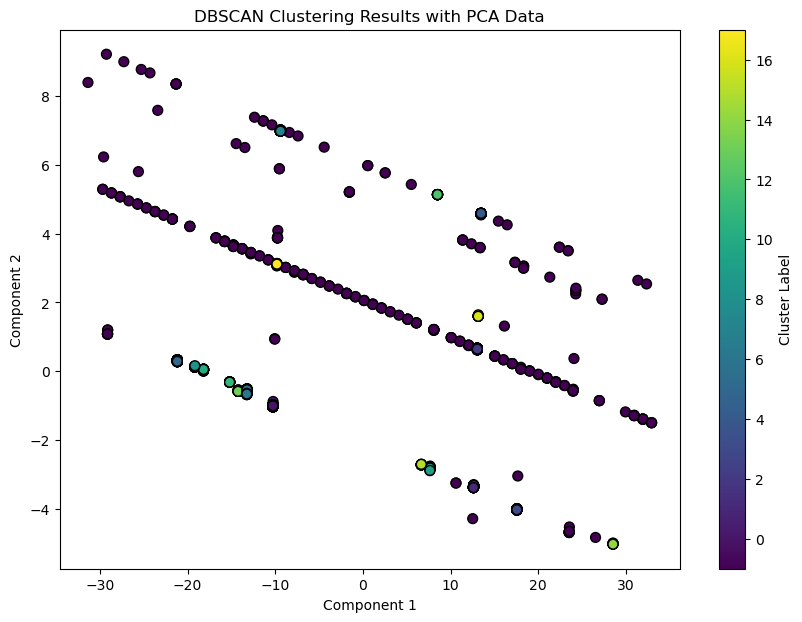

In [335]:
import pickle
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

# Load the trained DBSCAN model from the pickle file
with open('dbscan_model.pkl', 'rb') as file:
    dbscan_model = pickle.load(file)

# Assuming X_train_stra is your original data (the same data used to train the PCA)
# Apply PCA transformation (use the same PCA parameters as used before)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_stra)  # Ensure to use the same PCA fitting for new data

# Predict clusters using the loaded DBSCAN model
labels = dbscan_model.fit_predict(X_train_pca)

# Print the number of clusters and noise points
unique_labels = np.unique(labels)
num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)  # Exclude noise label
num_noise_points = np.sum(labels == -1)

print(f'Number of clusters: {num_clusters}')
print(f'Number of noise points: {num_noise_points}')

# Plotting function
def plot_clustering_results(X, labels, title='Clustering Results'):
    plt.figure(figsize=(10, 7))
    
    # Ensure X is a NumPy array
    if isinstance(X, pd.DataFrame):
        X = X.values
    
    # Check if data is 2D for plotting
    if X.ndim != 2 or X.shape[1] != 2:
        raise ValueError("Data must be 2D for plotting.")
    
    print(f"Plotting data shape: {X.shape}")
    print(f"Labels: {np.unique(labels)}")
    
    # Plot inliers
    scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k', s=50)
    
    # Add color bar
    plt.colorbar(scatter, label='Cluster Label')
    
    # Add title and labels
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    
    # Show plot
    plt.show()

# Plot the clustering results
plot_clustering_results(X_train_pca, labels, title='DBSCAN Clustering Results with PCA Data')


#### View the robustness DBSCAN to outliers


Number of clusters: 18
Number of noise points: 288
Plotting data shape: (5824, 2)
Labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


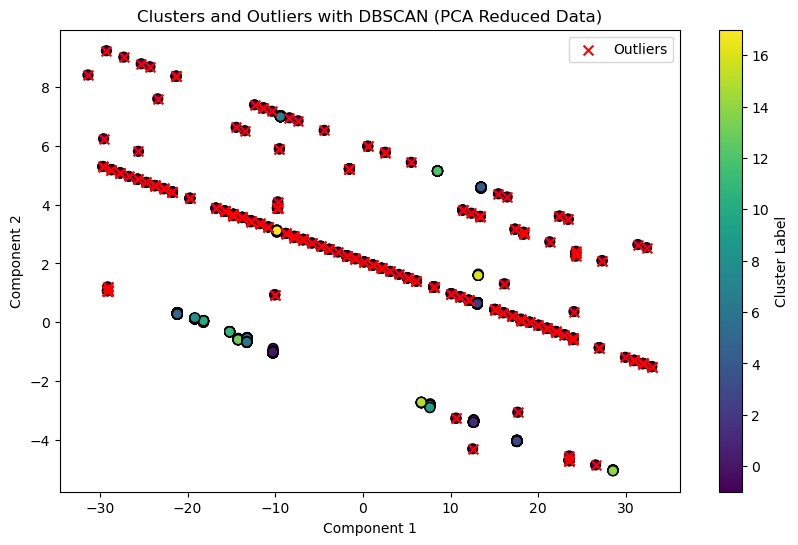

In [338]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

# Load the trained DBSCAN model from the pickle file
with open('dbscan_model.pkl', 'rb') as file:
    dbscan_model = pickle.load(file)

# Assuming X_train_stra is your original data
# Apply PCA transformation (use the same PCA parameters as used before)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_stra)  # Apply PCA to the data

# Predict clusters using the loaded DBSCAN model
labels = dbscan_model.fit_predict(X_train_pca)

# Print the number of clusters and noise points
unique_labels = np.unique(labels)
num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)  # Exclude noise label
num_noise_points = np.sum(labels == -1)

print(f'Number of clusters: {num_clusters}')
print(f'Number of noise points: {num_noise_points}')

def plot_with_outliers(X, labels):
    plt.figure(figsize=(10, 6))
    
    # Ensure X is a NumPy array
    if isinstance(X, pd.DataFrame):
        X = X.values
    
    # Check if data is 2D
    if X.ndim != 2 or X.shape[1] != 2:
        raise ValueError("Data must be 2D for plotting. Use dimensionality reduction techniques if necessary.")
    
    print(f"Plotting data shape: {X.shape}")
    print(f"Labels: {np.unique(labels)}")
    
    # Plot inliers
    scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k', s=50)
    
    # Plot outliers
    plt.scatter(X[labels == -1][:, 0], X[labels == -1][:, 1], c='red', marker='x', s=50, label='Outliers')
    
    # Add color bar
    plt.colorbar(scatter, label='Cluster Label')
    
    # Add title and labels
    plt.title("Clusters and Outliers with DBSCAN (PCA Reduced Data)")
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    
    # Add legend
    plt.legend()
    
    # Show plot
    plt.show()

# Call the function with PCA-reduced data and DBSCAN results
plot_with_outliers(X_train_pca, labels)


## HDBSCAN 

In [341]:
import hdbscan

hdbscan_config = {
    'HDBSCAN': (
        hdbscan.HDBSCAN, 
        [
            {
                'min_cluster_size': min_cluster_size,  
                'min_samples': min_samples,  
                'cluster_selection_epsilon': epsilon,  
                'alpha': alpha,  
                'metric': metric  
            }
            for min_cluster_size in [5, 10, 20]
            for min_samples in [5, 10]
            for epsilon in [0.0, 0.1, 0.2]
            for alpha in [1.0, 1.5, 2.0]
            for metric in ['euclidean', 'manhattan']
        ]
    )
}

# Evaluate HDBSCAN on the Random Sample dataset
hdbscan_results = []

# Run only for the random dataset
X, y = X_train_stra, y_train_stra
dataset = "Stratify"

print(f"\n{'='*20} Evaluating {dataset} Dataset with HDBSCAN {'='*20}\n")
hdbscan_results = iterative_evaluation(X, y, hdbscan_config, dataset, selfEvaluate=False)

# Convert results to DataFrame for further analysis
df_hdbscan = pd.DataFrame(hdbscan_results)
print(df_hdbscan.head())



==================== Evaluating Stratify Dataset with HDBSCAN ====================


Evaluating Stratify with HDBSCAN, params: {'min_cluster_size': 5, 'min_samples': 5, 'cluster_selection_epsilon': 0.0, 'alpha': 1.0, 'metric': 'euclidean'}, PCA = True
0.12070361558212231 0.022783009070014525 1.1033949016490827

Evaluating Stratify with HDBSCAN, params: {'min_cluster_size': 5, 'min_samples': 5, 'cluster_selection_epsilon': 0.0, 'alpha': 1.0, 'metric': 'euclidean'}, PCA = False
-0.18561622734229744 0.04405428413703509 1.1554030108722657

Evaluating Stratify with HDBSCAN, params: {'min_cluster_size': 5, 'min_samples': 5, 'cluster_selection_epsilon': 0.0, 'alpha': 1.0, 'metric': 'manhattan'}, PCA = True
0.11773516362874448 0.034410151758870695 1.1361566306948696

Evaluating Stratify with HDBSCAN, params: {'min_cluster_size': 5, 'min_samples': 5, 'cluster_selection_epsilon': 0.0, 'alpha': 1.0, 'metric': 'manhattan'}, PCA = False
0.21251656431715096 0.33036210099609237 1.4912620411818245

E

In [342]:
# Calculate combined scores
df_hdbscan = create_combined_score(df_hdbscan)
df_hdbscan.to_csv("hdbscan_finetuning.csv")
# Find the row with the highest combined score
best_model_row = df_hdbscan.loc[df_hdbscan['Combined_Score'].idxmax()]

# Print best model details
print("Best Model Details:")
print(best_model_row)


Best Model Details:
DataType                                                                                                                         Stratify
Model                                                                                                                             HDBSCAN
PCA                                                                                                                                  True
Params                 {'min_cluster_size': 10, 'min_samples': 10, 'cluster_selection_epsilon': 0.0, 'alpha': 1.0, 'metric': 'euclidean'}
Silhouette                                                                                                                       0.887514
ARI                                                                                                                              0.457239
Davies-Bouldin                                                                                                                   1.229715
Silhouette_Nor

In [348]:
pd.set_option('display.max_colwidth', None)
# Sort the DataFrame by 'Combined_Score' in descending order
df_hdbscan_sorted = df_hdbscan.sort_values(by='Combined_Score', ascending=False)

# Select only the 'Params' and 'Combined_Score' columns
df_hdbscan_sorted_filtered = df_hdbscan_sorted[['PCA','Params', 'Combined_Score']]

# Print the filtered DataFrame
df_hdbscan_sorted_filtered

,PCA,Params,Combined_Score
108,True,"{'min_cluster_size': 10, 'min_samples': 10, 'cluster_selection_epsilon': 0.0, 'alpha': 1.0, 'metric': 'euclidean'}",0.945557
116,True,"{'min_cluster_size': 10, 'min_samples': 10, 'cluster_selection_epsilon': 0.0, 'alpha': 2.0, 'metric': 'euclidean'}",0.945342
112,True,"{'min_cluster_size': 10, 'min_samples': 10, 'cluster_selection_epsilon': 0.0, 'alpha': 1.5, 'metric': 'euclidean'}",0.945342
110,True,"{'min_cluster_size': 10, 'min_samples': 10, 'cluster_selection_epsilon': 0.0, 'alpha': 1.0, 'metric': 'manhattan'}",0.915548
114,True,"{'min_cluster_size': 10, 'min_samples': 10, 'cluster_selection_epsilon': 0.0, 'alpha': 1.5, 'metric': 'manhattan'}",0.911786
...,...,...,...
6,True,"{'min_cluster_size': 5, 'min_samples': 5, 'cluster_selection_epsilon': 0.0, 'alpha': 1.5, 'metric': 'manhattan'}",0.421703
10,True,"{'min_cluster_size': 5, 'min_samples': 5, 'cluster_selection_epsilon': 0.0, 'alpha': 2.0, 'metric': 'manhattan'}",0.421158
9,False,"{'min_cluster_size': 5, 'min_samples': 5, 'cluster_selection_epsilon': 0.0, 'alpha': 2.0, 'metric': 'euclidean'}",0.336565
5,False,"{'min_cluster_size': 5, 'min_samples': 5, 'cluster_selection_epsilon': 0.0, 'alpha': 1.5, 'metric': 'euclidean'}",0.336565


### Best HDBSCAN Model

In [352]:
import pickle
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import hdbscan

# Assuming X_train_stra is your original data
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_stra)

# Define HDBSCAN parameters based on your data
hdbscan_params = {
    'min_cluster_size': 10,
    'min_samples': 10,
    'cluster_selection_epsilon': 0.0,
    'alpha': 1.0,
    'metric': 'euclidean'
}

# Initialize and fit the HDBSCAN model
hdbscan_model = hdbscan.HDBSCAN(**hdbscan_params)
hdbscan_model.fit(X_train_pca)

# Save the trained model to a pickle file
with open('hdbscan_model.pkl', 'wb') as file:
    pickle.dump(hdbscan_model, file)

print("HDBSCAN model saved as 'hdbscan_model.pkl'")


HDBSCAN model saved as 'hdbscan_model.pkl'


Number of clusters: 31
Number of noise points: 219
Plotting data shape: (5824, 2)
Labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30]


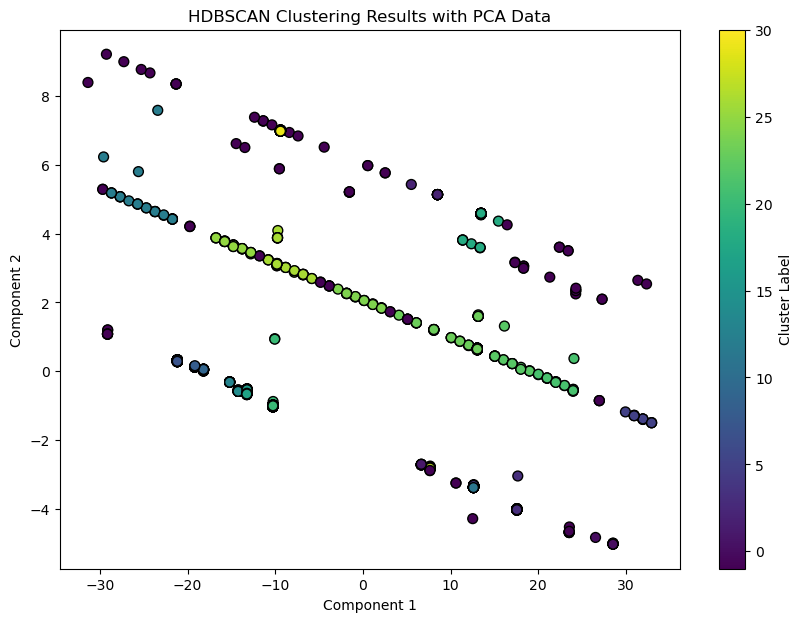

In [362]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import hdbscan

# Load the trained HDBSCAN model from the pickle file
with open('hdbscan_model.pkl', 'rb') as file:
    hdbscan_model = pickle.load(file)

# Assuming X_train_stra is your original data (the same data used to train the PCA)
# Apply PCA transformation (use the same PCA parameters as used before)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_stra)  # Ensure to use the same PCA fitting for new data

# Predict clusters using the loaded HDBSCAN model
labels = hdbscan_model.fit_predict(X_train_pca)

# Print the number of clusters and noise points
unique_labels = np.unique(labels)
num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)  # Exclude noise label
num_noise_points = np.sum(labels == -1)

print(f'Number of clusters: {num_clusters}')
print(f'Number of noise points: {num_noise_points}')

# Plotting function without outliers
def plot_clustering_results(X, labels, title='Clustering Results'):
    plt.figure(figsize=(10, 7))
    
    # Ensure X is a NumPy array
    if isinstance(X, pd.DataFrame):
        X = X.values
    
    # Check if data is 2D for plotting
    if X.ndim != 2 or X.shape[1] != 2:
        raise ValueError("Data must be 2D for plotting.")
    
    print(f"Plotting data shape: {X.shape}")
    print(f"Labels: {np.unique(labels)}")
    
    # Plot inliers
    scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k', s=50)
    
    # Add color bar
    plt.colorbar(scatter, label='Cluster Label')
    
    # Add title and labels
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    
    # Show plot
    plt.show()

# Plot the clustering results without outliers
plot_clustering_results(X_train_pca, labels, title='HDBSCAN Clustering Results with PCA Data')


Number of clusters: 31
Number of noise points: 219
Plotting data shape: (5824, 2)
Labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30]


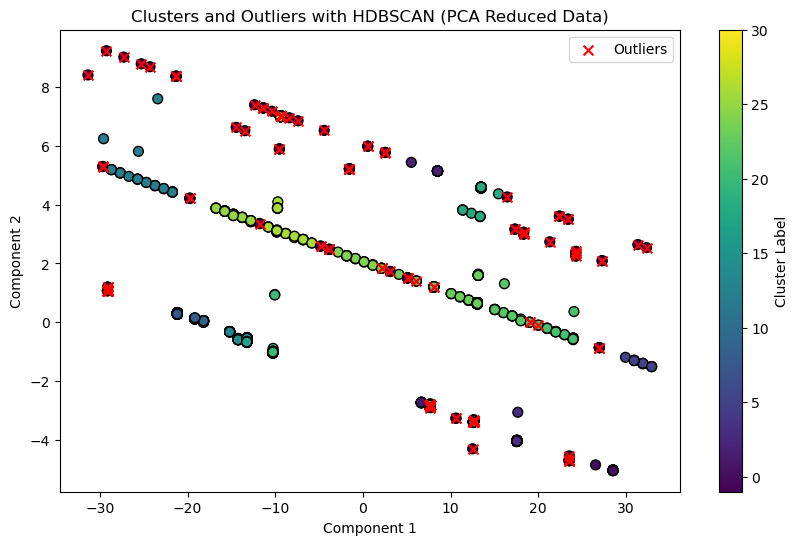

In [358]:
import pickle
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import hdbscan

# Load the trained HDBSCAN model from the pickle file
with open('hdbscan_model.pkl', 'rb') as file:
    hdbscan_model = pickle.load(file)

# Assuming X_train_stra is your original data
# Apply PCA transformation (use the same PCA parameters as used before)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_stra)  # Apply PCA to the data

# Predict clusters using the loaded HDBSCAN model
labels = hdbscan_model.fit_predict(X_train_pca)  # or fit_predict if needed

# Print the number of clusters and noise points
unique_labels = np.unique(labels)
num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)  # Exclude noise label
num_noise_points = np.sum(labels == -1)

print(f'Number of clusters: {num_clusters}')
print(f'Number of noise points: {num_noise_points}')

# Plotting
def plot_with_outliers(X, labels):
    plt.figure(figsize=(10, 6))
    
    # Ensure X is a NumPy array
    if isinstance(X, pd.DataFrame):
        X = X.values
    
    # Check if data is 2D
    if X.ndim != 2 or X.shape[1] != 2:
        raise ValueError("Data must be 2D for plotting. Use dimensionality reduction techniques if necessary.")
    
    print(f"Plotting data shape: {X.shape}")
    print(f"Labels: {np.unique(labels)}")
    
    # Plot inliers
    scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k', s=50)
    
    # Plot outliers
    plt.scatter(X[labels == -1][:, 0], X[labels == -1][:, 1], c='red', marker='x', s=50, label='Outliers')
    
    # Add color bar
    plt.colorbar(scatter, label='Cluster Label')
    
    # Add title and labels

    plt.title("Clusters and Outliers with HDBSCAN (PCA Reduced Data)")
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    
    # Add legend
    plt.legend()
    
    # Show plot
    plt.show()

# Call the function with PCA-reduced data and HDBSCAN results
plot_with_outliers(X_train_pca, labels)


## Birch

In [365]:
from sklearn.cluster import Birch

birch_config = {
    'Birch': (
        Birch,
        [
            {
                'n_clusters': n_clusters,
                'threshold': threshold,
                'branching_factor': branching_factor
            }
            for n_clusters in [None, 3, 5, 10,20]  # None for automatic clustering
            for threshold in [0.1, 0.5, 1.0]
            for branching_factor in [50, 100, 200]
        ]
    )
}
# Evaluate Birch on the Random Sample dataset
birch_results = []

# Run only for the random dataset
X, y = X_train_stra, y_train_stra
dataset = "Stratify"

print(f"\n{'='*20} Evaluating {dataset} Dataset with Birch {'='*20}\n")
birch_results = iterative_evaluation(X, y, birch_config, dataset, selfEvaluate=False)

# Convert results to DataFrame for further analysis
df_birch = pd.DataFrame(birch_results)
print(df_birch.head())


==================== Evaluating Stratify Dataset with Birch ====================


Evaluating Stratify with Birch, params: {'n_clusters': None, 'threshold': 0.1, 'branching_factor': 50}, PCA = True
0.9819052171081177 0.4572358205994079 0.06685691186693332

Evaluating Stratify with Birch, params: {'n_clusters': None, 'threshold': 0.1, 'branching_factor': 50}, PCA = False
0.3131266022075849 0.059761967898296416 0.4470689044603052

Evaluating Stratify with Birch, params: {'n_clusters': None, 'threshold': 0.1, 'branching_factor': 100}, PCA = True
0.9830128244988952 0.4572375136212941 0.05306012835494805

Evaluating Stratify with Birch, params: {'n_clusters': None, 'threshold': 0.1, 'branching_factor': 100}, PCA = False
0.3190438981439377 0.059437910621429724 0.4559362316021639

Evaluating Stratify with Birch, params: {'n_clusters': None, 'threshold': 0.1, 'branching_factor': 200}, PCA = True
0.9830128244887478 0.4572375136212941 0.05306012835531188

Evaluating Stratify with Birch, params:

In [366]:
# Calculate combined scores
df_birch = create_combined_score(df_birch)
df_birch.to_csv("birch_finetuning.csv")
# Find the row with the highest combined score
best_model_row = df_birch.loc[df_birch['Combined_Score'].idxmax()]

# Print best model details
print("Best Model Details:")
print(best_model_row)


Best Model Details:
DataType                                                                      Stratify
Model                                                                            Birch
PCA                                                                               True
Params                 {'n_clusters': None, 'threshold': 0.1, 'branching_factor': 100}
Silhouette                                                                    0.983013
ARI                                                                           0.457238
Davies-Bouldin                                                                 0.05306
Silhouette_Norm                                                                    1.0
ARI_Norm                                                                      0.789317
Davies-Bouldin_Norm                                                                1.0
Combined_Score                                                                0.929772
Name: 2, dtype: object


In [367]:
pd.set_option('display.max_colwidth', None)
# Sort the DataFrame by 'Combined_Score' in descending order
df_birch_sorted = df_birch.sort_values(by='Combined_Score', ascending=False)

# Select only the 'Params' and 'Combined_Score' columns
df_birch_sorted_filtered = df_birch_sorted[['PCA','Params', 'Combined_Score']]

# Print the filtered DataFrame
df_birch_sorted_filtered

,PCA,Params,Combined_Score
2,True,"{'n_clusters': None, 'threshold': 0.1, 'branching_factor': 100}",0.929772
4,True,"{'n_clusters': None, 'threshold': 0.1, 'branching_factor': 200}",0.929772
0,True,"{'n_clusters': None, 'threshold': 0.1, 'branching_factor': 50}",0.922589
8,True,"{'n_clusters': None, 'threshold': 0.5, 'branching_factor': 100}",0.830542
10,True,"{'n_clusters': None, 'threshold': 0.5, 'branching_factor': 200}",0.830542
...,...,...,...
71,False,"{'n_clusters': 10, 'threshold': 1.0, 'branching_factor': 200}",0.450728
69,False,"{'n_clusters': 10, 'threshold': 1.0, 'branching_factor': 100}",0.450728
5,False,"{'n_clusters': None, 'threshold': 0.1, 'branching_factor': 200}",0.150223
1,False,"{'n_clusters': None, 'threshold': 0.1, 'branching_factor': 50}",0.144189


In [371]:
import pickle
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import Birch

# Assuming X_train_stra is your original data
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_stra)

# Define BIRCH parameters based on your data
birch_params = {
    'n_clusters': None, 
    'threshold': 0.1, 
    'branching_factor': 100
}

# Initialize and fit the BIRCH model
birch_model = Birch(**birch_params)
birch_model.fit(X_train_pca)

# Save the trained model to a pickle file
with open('birch_model.pkl', 'wb') as file:
    pickle.dump(birch_model, file)

print("BIRCH model saved as 'birch_model.pkl'")


BIRCH model saved as 'birch_model.pkl'


Number of clusters: 112
Number of noise points: 0
Plotting data shape: (5824, 2)
Labels: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111]


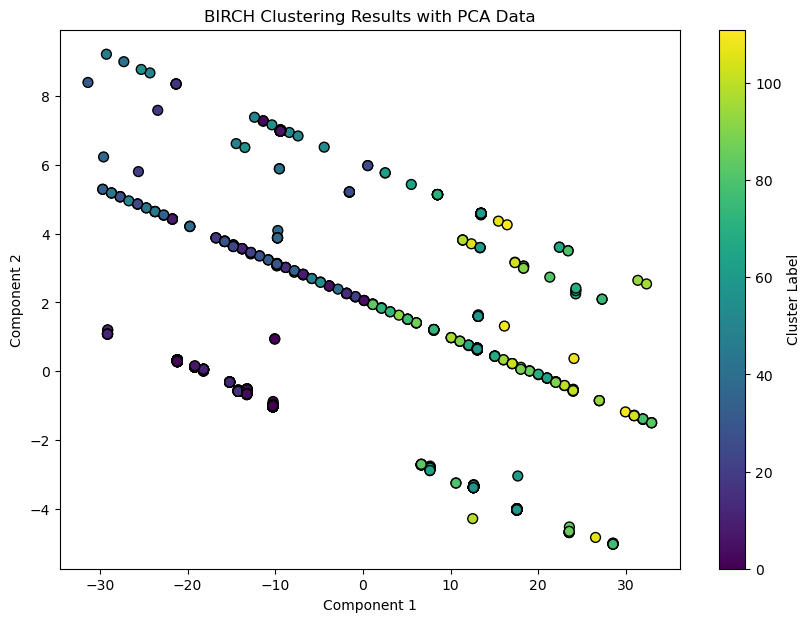

In [375]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import Birch

# Load the trained BIRCH model from the pickle file
with open('birch_model.pkl', 'rb') as file:
    birch_model = pickle.load(file)

# Assuming X_train_stra is your original data (the same data used to train the PCA)
# Apply PCA transformation (use the same PCA parameters as used before)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_stra)  # Ensure to use the same PCA fitting for new data

# Predict clusters using the loaded BIRCH model
labels = birch_model.predict(X_train_pca)

# Print the number of clusters and noise points
unique_labels = np.unique(labels)
num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)  # Exclude noise label
num_noise_points = np.sum(labels == -1)

print(f'Number of clusters: {num_clusters}')
print(f'Number of noise points: {num_noise_points}')

# Plotting function without outliers
def plot_clustering_results(X, labels, title='Clustering Results'):
    plt.figure(figsize=(10, 7))
    
    # Ensure X is a NumPy array
    if isinstance(X, pd.DataFrame):
        X = X.values
    
    # Check if data is 2D for plotting
    if X.ndim != 2 or X.shape[1] != 2:
        raise ValueError("Data must be 2D for plotting.")
    
    print(f"Plotting data shape: {X.shape}")
    print(f"Labels: {np.unique(labels)}")
    
    # Plot inliers
    scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k', s=50)
    
    # Add color bar
    plt.colorbar(scatter, label='Cluster Label')
    
    # Add title and labels
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    
    # Show plot
    plt.show()

# Plot the clustering results
plot_clustering_results(X_train_pca, labels, title='BIRCH Clustering Results with PCA Data')


Plotting data shape: (5824, 2)
Labels: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111]


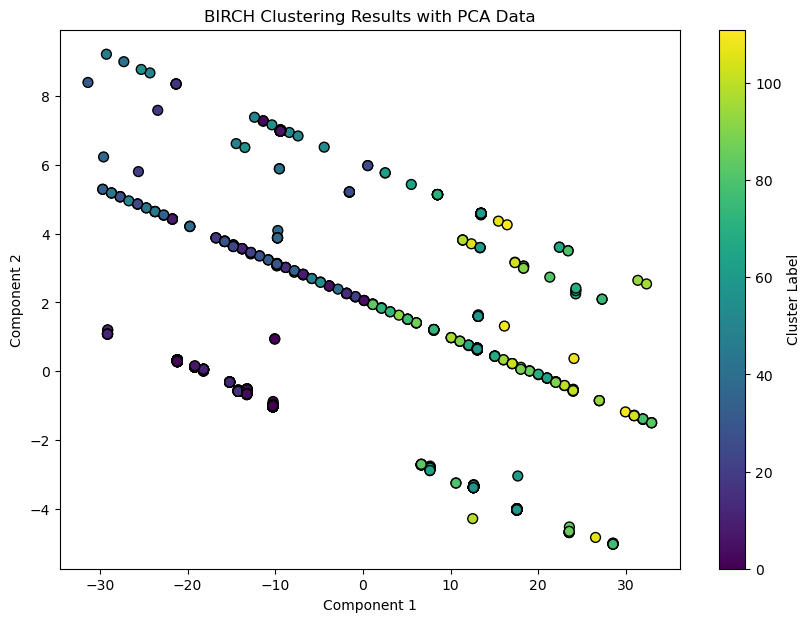

In [379]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import Birch

# Load the trained BIRCH model from the pickle file
with open('birch_model.pkl', 'rb') as file:
    birch_model = pickle.load(file)

# Assuming X_train_stra is your original data (the same data used to train the PCA)
# Apply PCA transformation (use the same PCA parameters as used before)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_stra)  # Ensure to use the same PCA fitting for new data

# Predict clusters using the loaded BIRCH model
labels = birch_model.predict(X_train_pca)

# Plotting function
def plot_clustering_results(X, labels, title='Clustering Results'):
    plt.figure(figsize=(10, 7))
    
    # Ensure X is a NumPy array
    if isinstance(X, pd.DataFrame):
        X = X.values
    
    # Check if data is 2D for plotting
    if X.ndim != 2 or X.shape[1] != 2:
        raise ValueError("Data must be 2D for plotting.")
    
    print(f"Plotting data shape: {X.shape}")
    print(f"Labels: {np.unique(labels)}")
    
    # Plot inliers
    scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k', s=50)
    
    # Add color bar
    plt.colorbar(scatter, label='Cluster Label')
    
    # Add title and labels
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    
    # Show plot
    plt.show()

# Plot the clustering results
plot_clustering_results(X_train_pca, labels, title='BIRCH Clustering Results with PCA Data')


## Ground-Truth Evalation 

In [494]:
results_df = pd.DataFrame(columns=[
    'Model Name',
    'Accuracy',
    'Conditional Entropy',
    'Silhouette Score',
    'ARI Score',
    'Davies-Bouldin Index',
    'Combined Score'
])

In [496]:
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, f1_score, classification_report

def normalize_metric(metric):
    scaler = MinMaxScaler()
    return scaler.fit_transform(metric.reshape(-1, 1)).flatten()

def get_labels(train_clusters, y_train):
    """Map clusters to the most frequent label."""
    clusters = np.unique(train_clusters)
    cluster_to_label_map = {}

    for i in clusters:
        indices = np.where(train_clusters == i)[0]
        labels = y_train.iloc[indices]
        counter_labels = labels.value_counts().to_dict()
        max_label = max(counter_labels, key=counter_labels.get)
        cluster_to_label_map[i] = max_label

    labels_in_string = np.array([cluster_to_label_map[cluster] for cluster in train_clusters])
    return cluster_to_label_map, labels_in_string

def groundTruthEvaluate(model_name, y_actual, y_pred, X):
    """Evaluate clustering results against ground truth and append to results list."""
    # Calculate accuracy
    accuracy = accuracy_score(y_actual, y_pred)
    print(classification_report(y_actual, y_pred, zero_division=0))
    
    # Calculate conditional entropy
    labels, counts = np.unique(y_actual, return_counts=True)
    entropy = -np.sum(counts / np.sum(counts) * np.log2(counts / np.sum(counts)))
    conditional_entropy = entropy / len(np.unique(y_pred))
    
    # Calculate Silhouette Score
    if len(np.unique(y_pred)) > 1 and len(y_pred) > len(np.unique(y_pred)):
        silhouette_avg = silhouette_score(X, y_pred)
    else:
        silhouette_avg = -1
    
    # Calculate ARI
    ari_score = adjusted_rand_score(y_actual, y_pred)
    
    # Calculate Davies-Bouldin Index
    if len(np.unique(y_pred)) > 1:
        dbi_score = davies_bouldin_score(X, y_pred)
        # Normalize Davies-Bouldin Index (invert it)
        dbi_normalized = 1 - normalize_metric(np.array([dbi_score]))[0]
    else:
        dbi_score = -1
        dbi_normalized = -1
    
    # Combine Scores
    combined_score = np.mean([silhouette_avg, ari_score, dbi_normalized])
    
    # Append the results as a row in the results list
    new_row = pd.DataFrame([{
        'Model Name': model_name,
        'Accuracy': accuracy,
        'Conditional Entropy': conditional_entropy,
        'Silhouette Score': silhouette_avg,
        'ARI Score': ari_score,
        'Davies-Bouldin Index': dbi_score,
        'Combined Score': combined_score
    }])
    
    global results_df
    results_df = pd.concat([results_df, new_row], ignore_index=True)

## Best DBSCAN Model Ground Truth Evaluation 

In [499]:
with open('hdbscan_model.pkl', 'rb') as file:
    hdbscan_model = pickle.load(file)

# Assuming X_train_stra is your original data (the same data used to train the PCA)
# Apply PCA transformation (use the same PCA parameters as used before)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_stra)  # Ensure to use the same PCA fitting for new data

# Predict clusters using the loaded DBSCAN model
dbscan_predicted_labels = dbscan_model.fit_predict(X_train_pca)
dbscan_cluster_to_label_map, dbscan_labels_in_string = get_labels(dbscan_predicted_labels, y_train_stra)
groundTruthEvaluate("DBSCAN-Train-PCA", y_train_stra, dbscan_labels_in_string, X_train_stra)

pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test_stra)
# Predict clusters using the loaded DBSCAN model
dbscan_predicted_labels = dbscan_model.fit_predict(X_test_pca)
dbscan_cluster_to_label_map, dbscan_labels_in_string = get_labels(dbscan_predicted_labels, y_test_stra)
groundTruthEvaluate("DBSCAN-Test-PCA", y_test_stra, dbscan_labels_in_string, X_test_stra)

with open('dbscan_cluster_label.pkl', 'wb') as file:
    pickle.dump(dbscan_cluster_to_label_map, file)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        39
           1       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         1
           5       0.59      0.91      0.71        22
           6       0.00      0.00      0.00         1
           9       0.97      1.00      0.99      2084
          10       0.00      0.00      0.00         7
          11       0.97      0.98      0.98      3508
          14       0.00      0.00      0.00         9
          15       1.00      0.56      0.71        18
          16       0.00      0.00      0.00         1
          17       1.00      0.61      0.76        31
          18       0.59      1.00      0.74        24
          20       0.00      0.00      0.00        36
          21       0.56      0.47      0.51        38

    accuracy                           0.97      5824
   macro avg       0.36   

C:\Users\User\AppData\Local\Temp\ipykernel_8420\3497571004.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


In [500]:
results_df

,Model Name,Accuracy,Conditional Entropy,Silhouette Score,ARI Score,Davies-Bouldin Index,Combined Score
0,DBSCAN-Train-PCA,0.965659,0.183327,-0.442239,0.921724,1.317027,0.493162
1,DBSCAN-Test-PCA,0.954670,0.324435,0.228051,0.890415,0.751114,0.706155


## Best HDBSCAN Model Ground Truth Evaluation 


In [502]:
import pickle
with open('hdbscan_model.pkl', 'rb') as file:
    hdbscan_model = pickle.load(file)

# Assuming X_train_stra is your original data (the same data used to train the PCA)
# Apply PCA transformation (use the same PCA parameters as used before)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_stra)  # Ensure to use the same PCA fitting for new data

# Predict clusters using the loaded DBSCAN model
hdbscan_predicted_labels = hdbscan_model.fit_predict(X_train_pca)
hdbscan_cluster_to_label_map, hdbscan_labels_in_string = get_labels(hdbscan_predicted_labels, y_train_stra)
groundTruthEvaluate("HDBSCAN-Train-PCA", y_train_stra, hdbscan_labels_in_string, X_train_stra)

pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test_stra)
# Predict clusters using the loaded DBSCAN model
hdbscan_predicted_labels = hdbscan_model.fit_predict(X_test_pca)
hdbscan_cluster_to_label_map, hdbscan_labels_in_string = get_labels(hdbscan_predicted_labels, y_test_stra)
groundTruthEvaluate("HDBSCAN-Test-PCA", y_test_stra, hdbscan_labels_in_string, X_test_stra)

with open('hdbscan_cluster_label.pkl', 'wb') as file:
    pickle.dump(hdbscan_cluster_to_label_map, file)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        39
           1       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         1
           5       0.59      0.91      0.71        22
           6       0.00      0.00      0.00         1
           9       0.98      0.97      0.97      2084
          10       0.00      0.00      0.00         7
          11       0.96      0.99      0.98      3508
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00        18
          16       0.00      0.00      0.00         1
          17       0.95      0.61      0.75        31
          18       0.59      1.00      0.74        24
          20       0.89      0.92      0.90        36
          21       0.56      0.47      0.51        38

    accuracy                           0.96      5824
   macro avg       0.35   

## Best Birch Model Ground Truth Evaluation 

In [506]:
# Load the trained BIRCH model from the pickle file
with open('birch_model.pkl', 'rb') as file:
    birch_model = pickle.load(file)

# Assuming X_train_stra is your original data (the same data used to train the PCA)
# Apply PCA transformation (use the same PCA parameters as used before)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_stra)  # Ensure to use the same PCA fitting for new data

# Predict clusters using the loaded BIRCH model
birch_predicted_labels = birch_model.fit_predict(X_train_pca)
birch_cluster_to_label_map, birch_labels_in_string = get_labels(birch_predicted_labels, y_train_stra)
groundTruthEvaluate("Birch-Train-PCA", y_train_stra, birch_labels_in_string, X_train_stra)

pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test_stra)
# Predict clusters using the loaded DBSCAN model
birch_predicted_labels = birch_model.fit_predict(X_test_pca)
birch_cluster_to_label_map, birch_labels_in_string = get_labels(birch_predicted_labels, y_test_stra)
groundTruthEvaluate("Birch-Test-PCA", y_test_stra, birch_labels_in_string, X_test_stra)


with open('birch_cluster_label.pkl', 'wb') as file:
    pickle.dump(birch_cluster_to_label_map, file)


              precision    recall  f1-score   support

           0       1.00      0.15      0.27        39
           1       0.00      0.00      0.00         2
           3       0.60      1.00      0.75         3
           4       0.00      0.00      0.00         1
           5       0.59      0.91      0.71        22
           6       0.00      0.00      0.00         1
           9       0.99      1.00      0.99      2084
          10       1.00      0.14      0.25         7
          11       0.97      0.99      0.98      3508
          14       0.00      0.00      0.00         9
          15       1.00      0.28      0.43        18
          16       0.00      0.00      0.00         1
          17       0.89      0.77      0.83        31
          18       0.59      1.00      0.74        24
          20       0.00      0.00      0.00        36
          21       0.56      0.47      0.51        38

    accuracy                           0.97      5824
   macro avg       0.51   

In [507]:
results_df

,Model Name,Accuracy,Conditional Entropy,Silhouette Score,ARI Score,Davies-Bouldin Index,Combined Score
0,DBSCAN-Train-PCA,0.965659,0.183327,-0.442239,0.921724,1.317027,0.493162
1,DBSCAN-Test-PCA,0.954670,0.324435,0.228051,0.890415,0.751114,0.706155
2,HDBSCAN-Train-PCA,0.962225,0.183327,-0.176346,0.905738,0.845780,0.576464
3,HDBSCAN-Test-PCA,0.955357,0.324435,0.062354,0.909797,0.827357,0.657384
4,Birch-Train-PCA,0.970810,0.128329,-0.198365,0.938793,2.414297,0.580143
5,Birch-Test-PCA,0.971154,0.185391,-0.046238,0.936863,1.831342,0.630208


### Bootstrap Stability 

In [509]:
bootstrap_result = None
def evaluate_clustering_metrics(model_name, y_actual, y_pred, X):
    from sklearn.metrics import accuracy_score, silhouette_score, adjusted_rand_score, davies_bouldin_score
    
    # Accuracy
    accuracy = accuracy_score(y_actual, y_pred)
    
    # Conditional entropy (simplified for illustration)
    labels, counts = np.unique(y_actual, return_counts=True)
    entropy = -np.sum(counts / np.sum(counts) * np.log2(counts / np.sum(counts)))
    conditional_entropy = entropy / len(np.unique(y_pred))
    
    # Silhouette Score
    if len(np.unique(y_pred)) > 1 and len(y_pred) > len(np.unique(y_pred)):
        silhouette_avg = silhouette_score(X, y_pred)
    else:
        silhouette_avg = -1  # Set to a default value when not computable
    
    # ARI (Adjusted Rand Index)
    ari_score = adjusted_rand_score(y_actual, y_pred)
    
    # Davies-Bouldin Index
    if len(np.unique(y_pred)) > 1:
        dbi_score = davies_bouldin_score(X, y_pred)
        dbi_normalized = 1 - normalize_metric(np.array([dbi_score]))[0]  # Inverted DBI
    else:
        dbi_score = -1  # Set to a default value when not computable
        dbi_normalized = -1
    
    # Combine Scores (set to a default if scores are uncomputable)
    if silhouette_avg != -1 and ari_score != -1 and dbi_normalized != -1:
        combined_score = np.mean([silhouette_avg, ari_score, dbi_normalized])
    else:
        combined_score = -1
    
    # Return all metrics, even if some are not computable (-1 indicates failure)
    return accuracy, conditional_entropy, silhouette_avg, ari_score, dbi_score, combined_score


def bootstrap_stability(X, y_true, clustering_algorithm, n_iterations=100, random_state=42):
    global bootstrap_result  # Declare the global variable
    
    results = []

    for i in range(n_iterations):
        # Generate a bootstrap sample
        X_sample = resample(X, random_state=random_state+i)
        y_sample = resample(y_true, random_state=random_state+i)
        
        # Apply clustering algorithm
        cluster_labels = clustering_algorithm.fit_predict(X_sample)
        
        # Map clusters to labels for accuracy (assuming y_true is available)
        _, y_pred = get_labels(cluster_labels, pd.Series(y_sample))
        
        # Calculate all metrics
        accuracy, conditional_entropy, silhouette_avg, ari_score, dbi_score, combined_score = evaluate_clustering_metrics(
            clustering_algorithm.__class__.__name__, y_sample, y_pred, X_sample)
        
        # Append results
        results.append({
            'Iteration': i+1,
            'Accuracy': accuracy,
            'Conditional Entropy': conditional_entropy,
            'Silhouette Score': silhouette_avg,
            'ARI Score': ari_score,
            'Davies-Bouldin Index': dbi_score,
            'Combined Score': combined_score
        })
    
    # Store results in global variable
    bootstrap_result = pd.DataFrame(results)
    
    # Calculate mean and standard deviation for each metric
    summary = bootstrap_result.describe().loc[['mean', 'std']]
    
    return summary

In [511]:
from sklearn.decomposition import PCA
from sklearn.utils import resample
# Load the HDBSCAN model
with open('hdbscan_model.pkl', 'rb') as file:
    hdbscan_model = pickle.load(file)

# Assuming X_train_stra is your original data (the same data used to train the PCA)
# Apply PCA transformation (use the same PCA parameters as used before)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_stra)  # Ensure to use the same PCA fitting for new data

# Perform bootstrap stability evaluation
metrics_mean_std = bootstrap_stability(X_pca, y_stra, hdbscan_model)

# Print the mean and std deviation of each metric
for metric, (mean_val, std_val) in metrics_mean_std.items():
    print(f"{metric.capitalize()} Mean: {mean_val:.4f}, Std Dev: {std_val:.4f}")

# Optionally, you can also save the global bootstrap_result to a CSV file
bootstrap_result.to_csv('hdbscan_bootstrap_results.csv', index=False)

Iteration Mean: 50.5000, Std Dev: 29.0115
Accuracy Mean: 0.9514, Std Dev: 0.0203
Conditional entropy Mean: 0.1732, Std Dev: 0.0218
Silhouette score Mean: -0.3138, Std Dev: 0.1870
Ari score Mean: 0.8622, Std Dev: 0.0686
Davies-bouldin index Mean: 1.1757, Std Dev: 0.2652
Combined score Mean: 0.5161, Std Dev: 0.0716


In [42]:
import pandas as pd
# Compute min and max values for relevant columns
min_max_values = {
    'Column': [
        'src_bytes', 'dst_bytes', 'wrong_fragment', 'num_compromised', 
        'count', 'srv_count', 'dst_host_srv_count', 'dst_host_same_src_port_rate'
    ],
    'Min': [
        data['src_bytes'].min(), data['dst_bytes'].min(), data['wrong_fragment'].min(), 
        data['num_compromised'].min(), data['count'].min(), data['srv_count'].min(), 
        data['dst_host_srv_count'].min()
        data['dst_host_same_src_port_rate'].min()
    ],
    'Max': [
        data['src_bytes'].max(), data['dst_bytes'].max(), data['wrong_fragment'].max(), 
        data['num_compromised'].max(), data['count'].max(), data['srv_count'].max(), 
        data['dst_host_srv_count'].max(),
        'dst_host_same_src_port_rate'.max()
    ]
}

# Create a DataFrame from the dictionary
min_max_df = pd.DataFrame(min_max_values)

# Save to CSV
min_max_df.to_csv('min_max_values.csv', index=False)


### Deployment

In [3]:
import numpy as np
import pandas as pd
import random

# Define min and max values for the integer columns
min_max_values = {
    'src_bytes': {'Min': 0, 'Max': 100000},
    'dst_bytes': {'Min': 0, 'Max': 100000},
    'wrong_fragment': {'Min': 0, 'Max': 3},
    'num_compromised': {'Min': 0, 'Max': 100},
    'count': {'Min': 0, 'Max': 500},
    'srv_count': {'Min': 0, 'Max': 500},
    'dst_host_srv_count': {'Min': 0, 'Max': 500},
    'dst_host_same_src_port_rate': {'Min': 0.0, 'Max': 1.0}
}

protocol_types = ['tcp', 'udp', 'icmp']
services = ['http', 'smtp', 'finger', 'domain_u', 'auth', 'telnet', 'ftp', 'eco_i', 'ntp_u', 'ecr_i', 'other', 
                'private', 'pop_3', 'ftp_data', 'rje', 'time', 'mtp', 'link', 'remote_job', 'gopher', 'ssh', 'name', 
                'whois', 'domain', 'login', 'imap4', 'daytime', 'ctf', 'nntp', 'shell', 'IRC', 'nnsp', 'http_443', 'exec', 
                'printer', 'efs', 'courier', 'uucp', 'klogin', 'kshell', 'echo', 'discard', 'systat', 'supdup', 'iso_tsap', 
                'hostnames', 'csnet_ns', 'pop_2', 'sunrpc', 'uucp_path', 'netbios_ns', 'netbios_ssn', 'netbios_dgm', 
                'sql_net', 'vmnet', 'bgp', 'Z39_50', 'ldap', 'netstat', 'urh_i', 'X11', 'urp_i', 'pm_dump', 'tftp_u', 
                'tim_i', 'red_i']
flags = ['SF', 'S1', 'REJ', 'S2', 'S0', 'S3', 'RSTO', 'RSTR', 'RSTOS0', 'OTH', 'SH']

# Function to simulate one row of data
def simulate_data_row():
    data = {
        'protocol_type': random.choice(protocol_types),
        'service': random.choice(services),
        'flag': random.choice(flags),
        'src_bytes': np.random.randint(min_max_values['src_bytes']['Min'], min_max_values['src_bytes']['Max']),
        'dst_bytes': np.random.randint(min_max_values['dst_bytes']['Min'], min_max_values['dst_bytes']['Max']),
        'wrong_fragment': np.random.randint(min_max_values['wrong_fragment']['Min'], min_max_values['wrong_fragment']['Max']),
        'logged_in': random.choice([0, 1]),  # Binary choice for logged_in
        'num_compromised': np.random.randint(min_max_values['num_compromised']['Min'], min_max_values['num_compromised']['Max']),
        'is_guest_login': random.choice([0, 1]),  # Binary choice for is_guest_login
        'count': np.random.randint(min_max_values['count']['Min'], min_max_values['count']['Max']),
        'srv_count': np.random.randint(min_max_values['srv_count']['Min'], min_max_values['srv_count']['Max']),
        'dst_host_srv_count': np.random.randint(min_max_values['dst_host_srv_count']['Min'], min_max_values['dst_host_srv_count']['Max']),
        'dst_host_same_src_port_rate': np.random.uniform(min_max_values['dst_host_same_src_port_rate']['Min'], min_max_values['dst_host_same_src_port_rate']['Max'])
    }
    return data

# Generate a DataFrame with multiple simulated rows
n_samples = 50  # Specify the number of samples you want to simulate
simulated_data = [simulate_data_row() for _ in range(n_samples)]
df_simulated = pd.DataFrame(simulated_data)

# Print the first few rows of simulated data
print(df_simulated.head())

# Save the simulated data to a CSV file
df_simulated.to_csv('simulate_data.csv',index=False)

  protocol_type   service flag  src_bytes  dst_bytes  wrong_fragment  \
0           tcp   courier   SH      95730      72483               2   
1          icmp     urh_i   S3      50759      21240               0   
2           udp   courier   S2      48841       8793               1   
3          icmp  http_443   SF      29438      84352               2   
4           udp     pop_3   S0      57254      24046               2   

   logged_in  num_compromised  is_guest_login  count  srv_count  \
0          0               16               1    417         43   
1          0               10               1    414        178   
2          1               20               1    451        259   
3          1               83               1     55        445   
4          0               66               0    384        363   

   dst_host_srv_count  dst_host_same_src_port_rate  
0                 162                     0.083123  
1                 257                     0.400608  
2    

In [517]:
# Run Streamlit app
!streamlit run app.py


Traceback (most recent call last):
  File "C:\Users\User\anaconda3\Scripts\streamlit-script.py", line 6, in <module>
    from streamlit.cli import main
ModuleNotFoundError: No module named 'streamlit.cli'


In [6]:
%%writefile app.py
import streamlit as st
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Load necessary models and label mappings
with open('label_encoders.pkl', 'rb') as f:
    label_encoders = pickle.load(f)

with open('model/agglo_model.pkl', 'rb') as f:
    aggloModel = pickle.load(f)

with open('model/agglo_cluster_label.pkl', 'rb') as f:
    agglo_cluster_to_label_map = pickle.load(f)

with open('pca_model.pkl', 'rb') as f:
    pca = pickle.load(f)

# Load the PCA-transformed training data saved in .npy format
X_train_pca = np.load("train_for_agglo.npy")

# Define label mapping function
def get_labels(predicted_labels, label_map):
    return [label_map.get(label, 'Unknown') for label in predicted_labels]

# Read min and max values from CSV file
min_max_df = pd.read_csv('min_max_values.csv', index_col='Column')
min_max_values = min_max_df.to_dict(orient='index')

# Feature lists
integer_cols = ['src_bytes', 'dst_bytes', 'wrong_fragment', 'num_compromised', 'count', 'srv_count', 'dst_host_srv_count','dst_host_same_src_port_rate']
nominal_cols = ['protocol_type', 'service', 'flag', 'logged_in', 'is_guest_login']

protocol_types = ['tcp', 'udp', 'icmp']
services = ['http', 'smtp', 'finger', 'domain_u', 'auth', 'telnet', 'ftp', 'eco_i', 'ntp_u', 'ecr_i', 'other', 
                'private', 'pop_3', 'ftp_data', 'rje', 'time', 'mtp', 'link', 'remote_job', 'gopher', 'ssh', 'name', 
                'whois', 'domain', 'login', 'imap4', 'daytime', 'ctf', 'nntp', 'shell', 'IRC', 'nnsp', 'http_443', 'exec', 
                'printer', 'efs', 'courier', 'uucp', 'klogin', 'kshell', 'echo', 'discard', 'systat', 'supdup', 'iso_tsap', 
                'hostnames', 'csnet_ns', 'pop_2', 'sunrpc', 'uucp_path', 'netbios_ns', 'netbios_ssn', 'netbios_dgm', 
                'sql_net', 'vmnet', 'bgp', 'Z39_50', 'ldap', 'netstat', 'urh_i', 'X11', 'urp_i', 'pm_dump', 'tftp_u', 
                'tim_i', 'red_i']
flags = ['SF', 'S1', 'REJ', 'S2', 'S0', 'S3', 'RSTO', 'RSTR', 'RSTOS0', 'OTH', 'SH']

# Streamlit app layout
st.title("Network Attack Clustering")

# User input for the features
st.subheader(">>> Input the network features:")

protocol_type = st.selectbox('Protocol Type', protocol_types)
service = st.selectbox('Network Service', services)
flag = st.selectbox('Flag (Status of the Connection)', flags)

logged_in = st.radio(
    'Successful Logged In?',
    options=[('Successful (1)', 1), ('Otherwise (0)', 0)],
    format_func=lambda x: x[0]
)

is_guest_login = st.radio(
    'Login as a "guest"?',
    options=[('Guest Login (1)', 1), ('Otherwise (0)', 0)],
    format_func=lambda x: x[0]
)

logged_in_value = logged_in[1]
is_guest_login_value = is_guest_login[1]

# Function to validate numerical input, allowing zero
def get_valid_input(prompt, min_val, max_val):
    input_val = st.text_input(prompt, value=str(min_val))
    try:
        int_val = int(input_val)
        if int_val < min_val or int_val > max_val:
            st.error(f"Please enter a value between {min_val} and {max_val}.")
            return None
        return int_val
    except ValueError:
        st.error("Please enter a valid integer.")
        return None

src_bytes = None
while src_bytes is None:
    src_bytes = get_valid_input('Source Bytes', int(min_max_values['src_bytes']['Min']), int(min_max_values['src_bytes']['Max']))

dst_bytes = None
while dst_bytes is None:
    dst_bytes = get_valid_input('Destination Bytes', int(min_max_values['dst_bytes']['Min']), int(min_max_values['dst_bytes']['Max']))

wrong_fragment = st.slider('Wrong Fragment', min_value=int(min_max_values['wrong_fragment']['Min']), max_value=int(min_max_values['wrong_fragment']['Max']), step=1)
num_compromised = st.slider('Number of Compromised', min_value=int(min_max_values['num_compromised']['Min']), max_value=int(min_max_values['num_compromised']['Max']), step=1)
count = st.slider('Count (Number of connections to the same host)', min_value=int(min_max_values['count']['Min']), max_value=int(min_max_values['count']['Max']), step=1)
srv_count = st.slider('Service Count (Number of connections to the same service)', min_value=int(min_max_values['srv_count']['Min']), max_value=int(min_max_values['srv_count']['Max']), step=1)
dst_host_srv_count = st.slider('Destination Host Service Count', min_value=int(min_max_values['dst_host_srv_count']['Min']), max_value=int(min_max_values['dst_host_srv_count']['Max']), step=1)
dst_host_same_src_port_rate = st.slider('Destination Host Same Source Port Rate', min_value=float(min_max_values['dst_host_same_src_port_rate']['Min']), max_value=float(min_max_values['dst_host_same_src_port_rate']['Max']), step=0.01)

# Prepare data for prediction
data = {
    'protocol_type': protocol_type,
    'service': service,
    'flag': flag,
    'src_bytes': src_bytes,
    'dst_bytes': dst_bytes,
    'wrong_fragment': wrong_fragment,
    'logged_in': logged_in_value,
    'num_compromised': num_compromised,
    'is_guest_login': is_guest_login_value,
    'count': count,
    'srv_count': srv_count,
    'dst_host_srv_count': dst_host_srv_count,
    'dst_host_same_src_port_rate': dst_host_same_src_port_rate
}

df = pd.DataFrame([data])

# Apply label encoding for nominal columns
for col in nominal_cols:
    if col in label_encoders:
        df[col] = label_encoders[col].transform(df[col])

# Apply log transformation to integer columns
for col in integer_cols:
    df[col] = np.log(df[col] + 1)

df = df.apply(pd.to_numeric, errors='coerce')

# Perform PCA transformation
df_pca = pca.transform(df)

if st.button('Predict'):
    try:
        # Check for any missing (NaN) values in the DataFrame
        missing_data = df.isnull().sum()
        if missing_data.any():
            st.write("Columns with missing values:")
            st.write(missing_data[missing_data > 0])
        else:
            # Calculate distances between the new data points and all training points
            distances = euclidean_distances(df_pca, X_train_pca)
            
            # Find the nearest training point for each new data point
            nearest_train_idx = np.argmin(distances, axis=1)
            
            # Assign the cluster label of the nearest training point to the new data point
            agglo_test_predicted_labels = aggloModel.labels_[nearest_train_idx]
            
            # Convert cluster labels to their corresponding string labels
            aggloPredictedTestStr = [agglo_cluster_to_label_map[cluster] for cluster in agglo_test_predicted_labels]
            
            st.write(f'Predicted cluster label: {agglo_test_predicted_labels}')
            st.write(f'Predicted cluster label string: {aggloPredictedTestStr[0]}')
                        
            train_cluster_labels_str = [agglo_cluster_to_label_map[cluster] for cluster in aggloModel.labels_]

            # Set up the figure
            fig, ax = plt.subplots()

            # Plot the PCA-transformed training data with cluster labels
            unique_labels = np.unique(train_cluster_labels_str)
            palette = sns.color_palette("husl", len(unique_labels))  # Choose a color palette for the clusters

            # Plot each cluster with its corresponding color
            for i, label in enumerate(unique_labels):
                idx = np.where(np.array(train_cluster_labels_str) == label)
                ax.scatter(X_train_pca[idx, 0], X_train_pca[idx, 1], 
                           label=label, color=palette[i], s=30, alpha=0.5)

            # Plot the predicted point
            ax.scatter(df_pca[0, 0], df_pca[0, 1], color='black', label='Predicted Point', s=100, edgecolor='red')

            # Add labels and legend
            ax.set_title('PCA-Transformed Data with Agglomerative Clustering Labels')
            ax.set_xlabel('PCA 1')
            ax.set_ylabel('PCA 2')
            ax.legend()

            # Display the plot
            st.pyplot(fig)

    except Exception as e:
        st.error(f"An error occurred: {e}")

def handle_unseen_labels(df, label_encoder, col_name):
    unseen_mask = ~df[col_name].isin(label_encoder.classes_)
    if unseen_mask.any():
        st.warning(f"Unseen labels found in column '{col_name}': {df[col_name][unseen_mask].unique()}")
        # Assign a default value (-1) to unseen labels
        df.loc[unseen_mask, col_name] = -1
    df[col_name] = label_encoder.transform(df[col_name].astype(str))

# Streamlit app layout
st.title("Network Attack Clustering")

# File uploader for user CSV
uploaded_file = st.file_uploader("Upload your CSV file for prediction", type=['csv'])

if uploaded_file is not None:
    # Read CSV file
    df_uploaded = pd.read_csv(uploaded_file)

    # Ensure necessary columns are present
    missing_columns = [col for col in integer_cols + nominal_cols if col not in df_uploaded.columns]

    if missing_columns:
        st.error(f"The following columns are missing in your CSV file: {missing_columns}")
    else:
        # Apply label encoding for nominal columns
        for col in nominal_cols:
            if col in label_encoders:
                try:
                    handle_unseen_labels(df_uploaded, label_encoders[col], col)
                except Exception as e:
                    st.error(f"Error encoding {col}: {e}")

        # Check for non-positive values in integer columns and display those rows
        for col in integer_cols:
            if col == 'wrong_fragment':
                # Allow zero values in 'wrong_fragment'
                if (df_uploaded[col] < 0).any():
                    non_positive_rows = df_uploaded[df_uploaded[col] < 0]
                    st.warning(f"Column '{col}' contains negative values. Showing those rows:")
                    st.write(non_positive_rows)
                    # Adjust negative values for log transformation
                    df_uploaded[col] = np.log(df_uploaded[col] + abs(min(df_uploaded[col])) + 1)
                else:
                    df_uploaded[col] = np.log(df_uploaded[col] + 1)
            else:
                # For other integer columns
                if (df_uploaded[col] <= 0).any():
                    non_positive_rows = df_uploaded[df_uploaded[col] <= 0]
                    st.warning(f"Column '{col}' contains non-positive values. Showing those rows:")
                    st.write(non_positive_rows)
                    # Adjust non-positive values for log transformation
                    df_uploaded[col] = np.log(df_uploaded[col] + abs(min(df_uploaded[col])) + 1)
                else:
                    df_uploaded[col] = np.log(df_uploaded[col] + 1)

        # Perform PCA transformation
        try:
            df_pca = pca.transform(df_uploaded)
        except ValueError as e:
            st.error(f"Error during PCA transformation: {e}")
            st.stop()

        # Calculate distances between the new data points and the training points
        distances = euclidean_distances(df_pca, X_train_pca)

        # Find the nearest training point for each new data point
        nearest_train_idx = np.argmin(distances, axis=1)

        # Assign the cluster label of the nearest training point to the new data points
        agglo_test_predicted_labels = aggloModel.labels_[nearest_train_idx]

        # Convert cluster labels to their corresponding string labels
        predicted_cluster_labels = get_labels(agglo_test_predicted_labels, agglo_cluster_to_label_map)

        # Add predicted labels to the DataFrame
        df_uploaded['Predicted_Label'] = predicted_cluster_labels
        st.write("Predictions:")
        st.write(df_uploaded[['Predicted_Label']])

        # Count occurrences of each predicted label
        label_counts = df_uploaded['Predicted_Label'].value_counts()
        st.write("Count of each predicted label:")
        st.write(label_counts)

        # Option to download the predictions
        csv_output = df_uploaded.to_csv(index=False)
        st.download_button(
            label="Download predictions as CSV",
            data=csv_output,
            file_name='predicted_labels.csv',
            mime='text/csv'
       )

Overwriting app.py


In [7]:
! streamlit run app.py & npx localtunnel --port 8501 --logger.level=debug


^C
